# Bootstrapping

In [1]:
from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Sampling with vs. without Replacement

Many questions of probability and statistics have to do with sampling from a population. Sometimes it is appropriate to imagine that the initial population is reset after each draw, and sometimes it is not.

Here's a case of the former: I go around interviewing people and I record their birthdays.

Clearly, two people can have the same birthday, and so I need each birthday to be available for every draw (i.e. interview). This is sampling **with replacement**. (One might even imagine that I interview some people more than once (by random chance).) Note in particular that draws in this context are mutually **independent**.

Here's a case of the latter: I am dealt thirteen cards to make a bridge hand. I can't have the same card appear twice in a single hand, so if I am thinking about the statistics of bridge hands, then I'm thinking about sampling **without replacement**.

Clearly this difference has an effect on correct calculation.

Consider these two similar cases:

**Case 1**: We're playing war. Each of us has a deck of cards, and we each turn over one card at a time, the player with the higher card collecting both. A tie in rank triggers "war", where more cards are laid down and then another contest is initiated on top of the now larger "pot" of cards.

Question: What are the chances that you and I turn over cards with the same rank on one round of war?

Answer: This is effectively a problem of cards drawn *with replacement*: I can just model this with two draws from a single deck. And so I calculate as follows:

I can draw any card first, so that's 52/52. The second card must match the first in rank, so that's 4/52. Thus the chances are $\frac{52}{52}\times\frac{4}{52} = \frac{1}{13}$.

**Case 2**: I am dealt a two-card blackjack hand from a single deck. (Good luck finding this game in Las Vegas!)

Question: What are the chances that I am dealt a pair?

Answer: The two events, one for each card being passed my way, are *not independent*. What the second card is likely to be is affected by what the first card is. For example, if the first card dealt me is the ace of spades, then there is now zero chance that the second card dealt me will be the ace of spades. (Whereas, if the first card is something else, then the chance that the second card be the ace of spades is greater than 0.) And so this is a problem of cards drawn *without replacement*.

So I calculate as follows:

I can draw any card first, so that's 52/52. The second card must match the first in rank, so that's 3/51. There are three left of whatever rank matches my first card, and 51 total cards left. Thus the chances are $\frac{52}{52}\times\frac{3}{51} = \frac{1}{17}$.

Bootstrapping is a sort of sampling ***with replacement***.

I can effect both sorts of sampling with the `choice()` function inside NumPy's `random` module:

In [24]:
X = ['red', 'green', 'blue']
np.random.choice(X)

'green'

Let's check the defaults of this function!

In [25]:
np.random.choice(X, size=3)

array(['red', 'red', 'blue'], dtype='<U5')

## Sampling from an Unknown Distribution

Bootstrapping is used when the shape of the population's distribution is unknown. To simulate this situation, let's make several distributions:

In [26]:
norm = stats.norm(loc=10, scale=5)
expon = stats.expon(loc=5, scale=5)
uni = stats.uniform(loc=5, scale=10)

dists = [norm, expon, uni]

Note that these distributions all have the same mean:

In [27]:
norm.mean() == expon.mean() == uni.mean() == 10

True

Plotting:

In [28]:
def plot_dists(dists, n=100):
    """Plot histograms of the distributions in dists."""
    fig, axs = plt.subplots(1, len(dists), figsize=(5*len(dists), 5))
    for ax, dist in zip(axs, dists):
        ax.hist(dist.rvs(10000))
        ax.set_xlim(0, 30)
    plt.show()

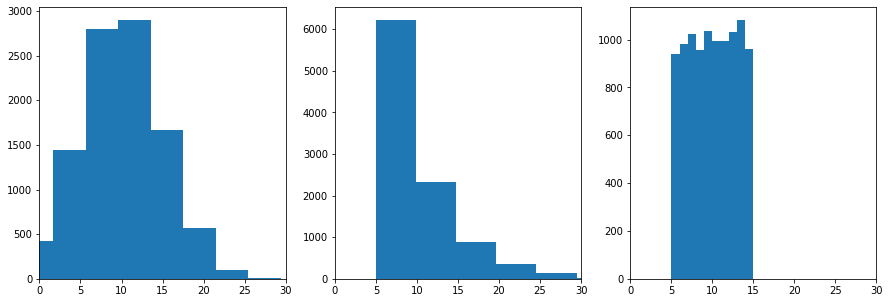

In [29]:
plot_dists(dists)

Choose a distribution at random:

In [30]:
dist = np.random.choice(dists)

Take a million points from it:

In [31]:
np.random.seed(42)
pop = dist.rvs(10**6)

Take a sample of 1000 from that million:

In [32]:
sample = np.random.choice(pop, size=1000)

In [33]:
len(sample)

1000

In [34]:
sample.mean()

10.027118575451397

The sample mean, $\bar{x}$, is *near* the population mean, $\mu$, but there's a certain gap between them.

## The Algorithm in Words

What we want to do now is what we just did, but *many* times. We can record statistics about each sample, and **then** do statistics on those statistics!

The idea is that statistics on this collection of samples, each made **with replacement**, will be a good approximation of the population parameters from which our original sample was drawn. And the more samples we take, the better our approximation should be. In this way we are "pulling ourselves up by our own bootstraps" to make inferences about the population as a whole.

**Note that we are NOT making inferences about the population distribution, but only about some population parameter of interest (like the mean).**

Let's see what happens when we record the mean and the 95th percentile of each sample:

In [35]:
np.random.seed(1)
bootstrap_samples = []                                                   # Initialize an empty list
bootstrap_sample_means = np.zeros(1000)                                  # Initialize an array of means
bootstrap_sample_95pcts = np.zeros(1000)                                 # And another of 95th percentiles
for i in range(1000):
    bootstrap_sample = np.random.choice(sample, size=1000)               # Take 1000 points from one of the dists
    bootstrap_samples.append(bootstrap_sample)                           # Add that to the list
    bootstrap_sample_means[i] = bootstrap_sample.mean()                  # Add the mean to the means' array
    bootstrap_sample_95pct = np.percentile(a=bootstrap_sample, q=95)
    bootstrap_sample_95pcts[i] = bootstrap_sample_95pct                  # Add the 95th percentile to the
                                                                         # percentiles'array

In [36]:
bootstrap_sample_means[:10]

array([ 9.97022399,  9.90818331, 10.08830978, 10.06652267, 10.04682762,
        9.78096397,  9.99266009, 10.05115169,  9.95249488, 10.20462156])

In [37]:
bootstrap_sample_95pcts[:10]

array([18.64300854, 17.61240691, 18.77891138, 18.85063152, 18.68131819,
       18.10338564, 18.26443328, 18.96294337, 18.26443328, 18.15578766])

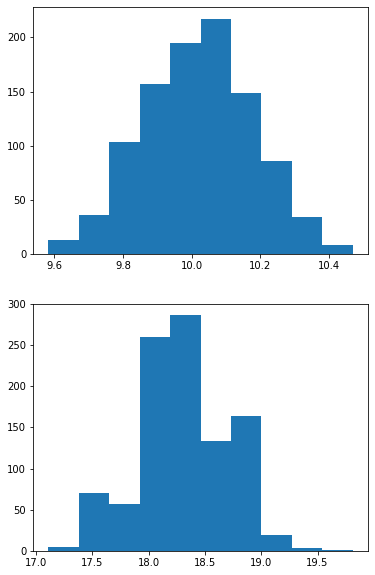

In [38]:
fig, ax = plt.subplots(2, figsize=(6, 10))
ax[0].hist(bootstrap_sample_means)
ax[1].hist(bootstrap_sample_95pcts);

In [39]:
sample.mean()

10.027118575451397

In [40]:
bootstrap_sample_means.mean()

10.019976458671037

In [41]:
pop.mean()

9.992001217728719

In [42]:
np.percentile(a=sample, q=95)

18.266122992205688

In [43]:
bootstrap_sample_95pcts.mean()

18.301356577603585

In [44]:
np.percentile(a=pop, q=95)

18.21319607565015

## Why Bootstrap?

[Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is helpful on this.

With a bootstrap we are simulating the relationship between population and sample by treating our sample as the population. In that case we can actually measure the error between our estimates (made through resampling) and the true sample statistics.

"Adèr et al. recommend the bootstrap procedure for the following situations (Adèr, H. J., Mellenbergh G. J., & Hand, D. J. (2008). *Advising on research methods: A consultant's companion*. Huizen, The Netherlands: Johannes van Kessel Publishing. ISBN 978-90-79418-01-5.):

- When the theoretical distribution of a statistic of interest is complicated or unknown. Since the bootstrapping procedure is distribution-independent it provides an indirect method to assess the properties of the distribution underlying the sample and the parameters of interest that are derived from this distribution.
- When the sample size is insufficient for straightforward statistical inference. If the underlying distribution is well-known, bootstrapping provides a way to account for the distortions caused by the specific sample that may not be fully representative of the population.
- When power calculations have to be performed, and a small pilot sample is available. Most power and sample size calculations are heavily dependent on the standard deviation of the statistic of interest. If the estimate used is incorrect, the required sample size will also be wrong. One method to get an impression of the variation of the statistic is to use a small pilot sample and perform bootstrapping on it to get impression of the variance."

## Bootstrapping as Comparison Tool

In the context of hypothesis testing, we can use bootstrapping to test whether there is a significant difference between two samples. The idea is this:

Suppose that Sample A and Sample B seem to be significantly different in some feature. Now, if we were (i) to throw A and B together into one big pool, and then (ii) to construct new samples (with replacement) from this pool, any similar difference we see between the samples we make would be evidence that the original difference between A and B was not significant after all. So if we do this sampling experiment lots of times, and we *rarely* see a difference between our two samples like we saw between A and B, then we can be confident that there is some significant difference between A and B.

Let's try this with the Instagram control and experimental groups:

In [45]:
control = pd.read_csv('data/control.csv', index_col=0)
experiment = pd.read_csv('data/experiment.csv', index_col=0)

In [46]:
def bootstrap(a, b):
    universe = np.append(a, b)
    universe_shuffled = np.random.choice(universe, size=len(universe), replace=True)
    new_a = universe_shuffled[:len(a)]
    new_b = universe_shuffled[len(a):]
    return new_a, new_b

In [47]:
grp_1 = control['Likes_Given_Con']
grp_2 = experiment['Likes_Given_Exp']
orig_mean = grp_2.mean() - grp_1.mean()
orig_mean

5.114285714285721

In [48]:
ctr = 0
samples = 10000
for _ in range(samples):
    a, b = bootstrap(grp_1, grp_2)
    if abs(a.mean() - b.mean()) > orig_mean:
        ctr += 1
print('p-value:' + str(ctr / samples))

p-value:0.0001


## Bootstrapping Real Data

Below we read in a dataset containing information about public toilets in Berlin.

In [49]:
berlin = pd.read_excel('data/20191101_berlinertoiletten-2.xlsx')

In [50]:
berlin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 18 columns):
LavatoryID                 254 non-null object
Description                254 non-null object
City                       254 non-null object
Street                     254 non-null object
Number                     158 non-null object
PostalCode                 254 non-null int64
Country                    254 non-null object
Longitude                  254 non-null float64
Latitude                   254 non-null float64
Datum_Aufbau               254 non-null datetime64[ns]
isOwnedByWall              254 non-null int64
isHandicappedAccessible    254 non-null int64
OperationalState           254 non-null int64
Price                      254 non-null float64
canBePayedWithCoins        254 non-null int64
canBePayedInApp            254 non-null int64
hasChangingTable           254 non-null int64
LabelID                    254 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8

In [51]:
berlin['Price'].mean()

0.3216535433070866

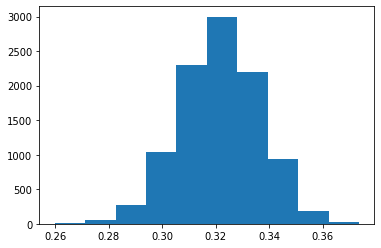

In [52]:
means = []

for _ in range(10000):
    sample = np.random.choice(berlin['Price'].values, size=len(berlin['Price']))
    means.append(np.mean(sample))

plt.hist(means);

To what extent could we use these results to draw inferences about public toilet prices in all of Germany? Or all of Europe? Or about past or future toilet prices?

## Bootstrapping in Linear Regression

[Here](https://www.textbook.ds100.org/ch/18/hyp_regression.html) is a great example of how we could use bootstrapping in the context of linear regression.

The basic idea is that we want some measure of the error of our coefficients. Bootstrapping to the rescue! If we fit *many* linear regressions to different bootstrapped samples of our data and calculate the coefficients each time, we can then have a distribution of coefficients that we can use as a confidence interval.

In [53]:
np.random.seed(42)
X, Y = make_regression(n_features=2, noise=5)

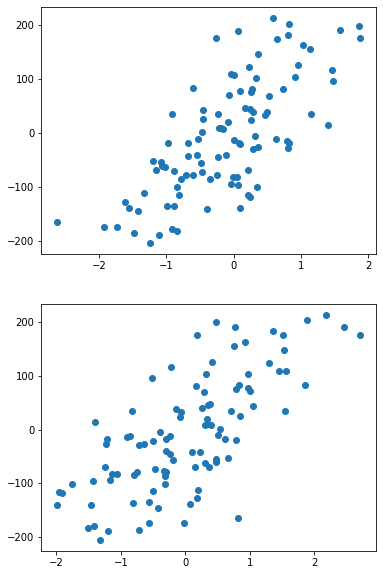

In [54]:
fig, ax = plt.subplots(2, figsize=(6, 10))
ax[0].scatter(X[:, 0], Y)
ax[1].scatter(X[:, 1], Y);

In [55]:
lr = LinearRegression()
lr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
lr.coef_

array([86.86994374, 74.09680794])

In [57]:
df = pd.DataFrame(X, columns=('X1', 'X2'))
df_plus_y = pd.concat([df, pd.Series(Y, name='Y')], axis=1)

In [58]:
# Now with bootstrapping

X1_coefs = []
for _ in range(1000):
    inds = np.random.choice(range(100), size=10)
    rows = df_plus_y.iloc[inds, :]
    lr = LinearRegression().fit(rows[['X1', 'X2']], rows['Y'])
    X1_coefs.append(lr.coef_[0])

In [59]:
coefs_sorted = sorted(X1_coefs)
print(coefs_sorted[24])
print(coefs_sorted[974])

80.97575027541465
91.4670795071104


## Bootstrapping Challenge


Suppose we had the following two samples of automobile MPG ratings. The question is whether Group 2 (the experimental group) has a significantly higher MPG rating than Group 1 (the control group).

First, we'll make some preliminary calculations and run a hypothesis test.

In [60]:
# Read in the files:

grp_1 = pd.read_csv('data/group1.csv', index_col=0, squeeze=True)
grp_2 = pd.read_csv('data/group2.csv', index_col=0, squeeze=True)

In [69]:
print(grp_1.mean(), grp_2.mean())

23.802089196211725 28.497425266757116


In [70]:
print(grp_1.shape, grp_2.shape)

(30,) (30,)


In [71]:
print(grp_1.std(), grp_2.std())

5.635829809583574 1.0301945014523644


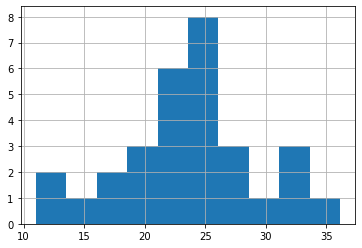

In [72]:
grp_1.hist();

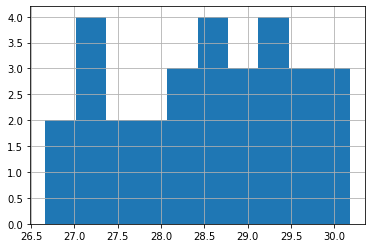

In [73]:
grp_2.hist();

In [74]:
stats.ttest_ind(grp_1, grp_2, equal_var=False)

Ttest_indResult(statistic=-4.48882177720608, pvalue=9.276193948136522e-05)

In [75]:
def Cohen_d(group1, group2):

    """
    Computes Cohen's d.
    """
    
    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1 = len(group1)
    n2 = len(group2)
    var1 = group1.var(ddof=1)
    var2 = group2.var(ddof=1)

    # Calculate the pooled threshold
    pooled_var = ((n1-1) * var1 + (n2-1) * var2) / (n1 + n2 - 2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [76]:
Cohen_d(grp_1, grp_2)

-1.1590087991474884

Exercise: Construct 10000 bootstrap samples of the *difference in means* between the two groups. Then order the differences and take the 250th and 9750th values to construct a 95%-confidence interval around our estimate of the difference.

In [81]:
# Now bootstrap!
mean_diffs = []
for _ in range(10000):
    s_1 = np.random.choice(grp_1, size=30)
    s_2 = np.random.choice(grp_2, size=30)
    diff = s_2.mean() - s_1.mean()
    mean_diffs.append(diff)
    
diffs_sorted = sorted(mean_diffs)
sorted_diffs_rounded = []

for diff in diffs_sorted:
    sorted_diffs_rounded.append(round(diff,3))

In [82]:
sorted_diffs_rounded[0:10]

[0.947, 0.96, 1.228, 1.24, 1.254, 1.264, 1.292, 1.458, 1.491, 1.504]